In [6]:
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy import signal
from scipy.fftpack import fft
from scipy import ndimage
%matplotlib inline

In [7]:
## EqualState assign states with equal possibility for input array x
def EqualState(x, num_state):
    xs=np.sort(x)
    binlen=int(len(x)/num_state-0.5) #round
    edges = xs[np.arange(num_state)*binlen]
    xstate=np.zeros(len(x))
    for i in range(num_state):
        xstate[x>=edges[i]] = i
    xstate = xstate.astype(int)
    return xstate

In [8]:
## PIfunc that calculate Unique, Synergy and Redundancy of three unsymmetric varibles
def PIfunc(r, x, v, dt, window):
    negshift=window[0] # second
    posshift=window[1] # second
    shiftlen=(posshift-negshift)/dt+1
    timeshift=np.linspace(negshift,posshift,int(shiftlen))
    bitshift=np.linspace(negshift/dt,posshift/dt,int(shiftlen),dtype = 'int8')
    Redun =np.zeros(len(bitshift))
    MIxr=np.zeros(len(bitshift))
    MIvr=np.zeros(len(bitshift))
    MIxvR=np.zeros(len(bitshift))
    # shifted data
    # shift>0 => y shifted to positive side
    for i in range(len(bitshift)):
        xx=[]
        vv=[]
        rr=[]
        shift=bitshift[i]
        if shift>0:
            xx=x[shift:]
            vv=v[shift:]
            rr=r[:-shift]
        elif shift==0:
            xx=x
            vv=v
            rr=r
        elif shift<0:
            xx=x[:shift]
            vv=v[:shift]
            rr=r[-shift:]
        #find weight of each states by 3D histogram 
        xedges = np.append(np.unique(xx),(max(xx)+1))
        vedges = np.append(np.unique(vv),(max(vv)+1))
        redges = np.append(np.unique(rr),(max(rr)+1))
        dat = np.concatenate((xx[:,np.newaxis], vv[:,np.newaxis],rr[:,np.newaxis]), axis=1)
        N, edges = np.histogramdd(dat, bins=(xedges, vedges, redges))
        #Calculate all kinds of probability and make sure the shape of them
        px=(np.sum(N,axis=(1,2))/np.sum(N))[:, np.newaxis, np.newaxis]
        pv=(np.sum(N,axis=(0,2))/np.sum(N))[np.newaxis, :, np.newaxis]
        pr=(np.sum(N,axis=(0,1))/np.sum(N))[np.newaxis ,np.newaxis, :]
        pxv=(np.sum(N,axis=2)/np.sum(N))[:, :, np.newaxis]
        pxr=(np.sum(N,axis=1)/np.sum(N))[:, np.newaxis, :]
        pvr=(np.sum(N,axis=0)/np.sum(N))[np.newaxis, :, :]
        pxvr=(N/np.sum(N))
        
        MIxr[i]=np.nansum(pxr*np.log2(pxr/px/pr))/dt
        MIvr[i]=np.nansum(pvr*np.log2(pvr/pv/pr))/dt
        MIxvR[i]=np.nansum(pxvr*np.log2(pxvr/pxv/pr))/dt
        
        PI_xR = np.nansum(pxr*np.log2(pxr/px/pr), axis = (0,1))
        PI_vR = np.nansum(pvr*np.log2(pvr/pv/pr), axis = (0,1))
        Redun[i] = sum(np.minimum(PI_xR, PI_vR))/dt
    return timeshift, MIxr, MIvr, MIxvR, Redun

In [9]:
def TransferEntropy(x, y, shift):#T(x->y)
    xx = x[:-shift]#x_past
    vv = y[:-shift]#y_past
    rr = y[shift:]#y_present
    xedges = np.append(np.unique(xx),(max(xx)+1))
    vedges = np.append(np.unique(vv),(max(vv)+1))
    redges = np.append(np.unique(rr),(max(rr)+1))
    dat = np.concatenate((xx[:,np.newaxis], vv[:,np.newaxis],rr[:,np.newaxis]), axis=1)
    N, edges = np.histogramdd(dat, bins=(xedges, vedges, redges))
    px=(np.sum(N,axis=(1,2))/np.sum(N))[:, np.newaxis, np.newaxis]
    pv=(np.sum(N,axis=(0,2))/np.sum(N))[np.newaxis, :, np.newaxis]
    pr=(np.sum(N,axis=(0,1))/np.sum(N))[np.newaxis ,np.newaxis, :]
    pxv=(np.sum(N,axis=2)/np.sum(N))[:, :, np.newaxis]
    pxr=(np.sum(N,axis=1)/np.sum(N))[:, np.newaxis, :]
    pvr=(np.sum(N,axis=0)/np.sum(N))[np.newaxis, :, :]
    pxvr=(N/np.sum(N))
    
    T = np.nansum(pxvr*np.log2(pxvr*pv/pxv/pvr))/dt
    return T

In [10]:
def  Shannon_entropy(serie):
    N , bin_edges = np.histogram(serie, bins=(np.append(np.unique(serie),(max(serie)+1))))
    p = N/np.sum(N)
    H = np.nansum(-1*p*np.log2(p))
    return H

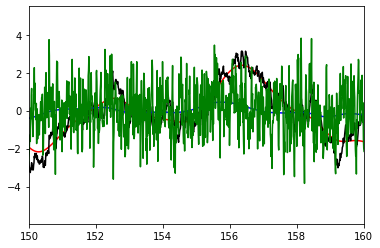

In [21]:
#main
# OU ; input
Tot=300
dt=0.01
T=np.arange(dt,Tot,dt)
tau=1
D = 4
L=np.zeros(len(T))
L2=np.zeros(len(T))
mu, sigma = 0, 1
for i in range(len(T)-1):
    noise = math.sqrt(D*dt)*np.random.normal(mu,sigma)
    L[i+1]=L[i]*(0.5-dt/tau)+noise
    L2[i+1] = L2[i]*(1-dt/tau)+noise
L=L*(max(L2)-min(L2))/(max(L)-min(L))
# filtering for OUSmoothed
cutoffFreq = 0.5
b, a = signal.butter(2, 2*cutoffFreq*dt, btype='low', analog=False)
x = signal.filtfilt(b, a, L)
x2 = signal.filtfilt(b, a, L2)
plt.plot(T,x2, 'r-')
plt.plot(T,L2, 'k-')
plt.plot(T,x, 'b-')
plt.plot(T,L, 'g-')
plt.xlim(150,160)

#v = ndimage.gaussian_filter1d(x, sigma=1, order=1, mode='wrap') / dt
v = np.diff(x)/dt
x=x[1:]
v=v[0:] #cut ends.  V(n) = X(n) -X(n-1)
T=T[1:]

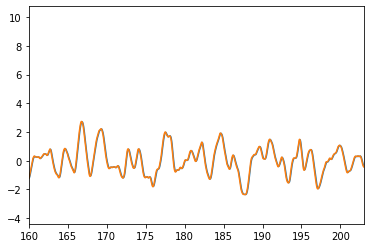

In [22]:
##response
# Model one: simple estimation
deltaT = 0.5
r1 = x+v*deltaT

# Model Two: negative group delay
#following paremeters match x+v*0.5s
alpha = 60.
beta =  2
K = 30.
g = 30.
#following paremeters match x+v*2s
# alpha = 19.9
# beta =  0.62
# K = 10
# g = 30
y=np.zeros(len(T))
z=np.zeros(len(T))
for j in range(len(T)-1):
    dy=dt*(-alpha*y[j]+K*(x[j]-z[j]))
    dz=dt*(-beta*z[j]+g*y[j])
    y[j+1]=y[j]+dy
    z[j+1]=z[j]+dz

y= y/np.std(y)
r1= r1/np.std(r1)
plt.plot(T,y)
plt.plot(T,r1)
plt.xlim(160,203)
    
#Chose which one to be response
r = r1

In [23]:
#assign states
edges = np.append(min(r), np.array([np.std(r),2*np.std(r),3*np.std(r)])+np.mean(r));
rstate=np.zeros(len(r))
for i in range(4):
    rstate[r>=edges[i]] = i
rstate = rstate.astype(int)
xstate = EqualState(x, 7)
vstate = EqualState(v, 6)

C:\Users\llinc\anaconda3\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: divide by zero encountered in log2
C:\Users\llinc\anaconda3\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in multiply
C:\Users\llinc\anaconda3\lib\site-packages\ipykernel_launcher.py:47: RuntimeWarning: divide by zero encountered in log2
C:\Users\llinc\anaconda3\lib\site-packages\ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered in multiply
C:\Users\llinc\anaconda3\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in log2
C:\Users\llinc\anaconda3\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in multiply
C:\Users\llinc\anaconda3\lib\site-packages\ipykernel_launcher.py:50: RuntimeWarning: divide by zero encountered in log2
C:\Users\llinc\anaconda3\lib\site-packages\ipykernel_launcher.py:50: RuntimeWarning: invalid value encountered in multiply
C:\Users\llinc\anaconda3\lib

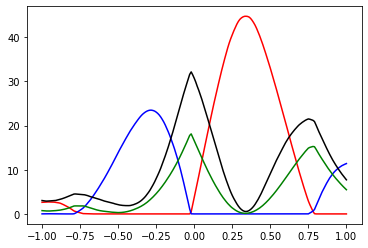

In [26]:
#calculate information
window = [-1,1] # second
timeshift, MIx, MIv, MIjoint, Redun = PIfunc(rstate, xstate, vstate, dt, window)
Ux = MIx-Redun
Uv = MIv-Redun
Syner = MIjoint-MIx-MIv+Redun
#plot PIs (r,x,v)
plt.plot(timeshift,Ux, 'r-')
plt.plot(timeshift,Uv, 'b-')
plt.plot(timeshift,Syner, 'k-')
plt.plot(timeshift,Redun, 'g-')

In [8]:
#calculate information
window = [0,0] # second
timeshift, MI1, MI2, MIjoint, Redun = PIfunc(rstate, xstate, vstate, dt, window)
I3 = -(MIjoint-MI1-MI2)
print(I3)
print(MIjoint)
print(Redun)

[-14.72762343]
[49.81743324]
[15.17185074]


C:\Users\llinc\anaconda3\lib\site-packages\ipykernel_launcher.py:44: RuntimeWarning: divide by zero encountered in log2
C:\Users\llinc\anaconda3\lib\site-packages\ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in multiply
C:\Users\llinc\anaconda3\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in log2
C:\Users\llinc\anaconda3\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in multiply
C:\Users\llinc\anaconda3\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: divide by zero encountered in log2
C:\Users\llinc\anaconda3\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in multiply
C:\Users\llinc\anaconda3\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in log2
C:\Users\llinc\anaconda3\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in multiply
C:\Users\llinc\anaconda3\lib

In [9]:
#calculate information
window = [0,0] # second
timeshift, MI1, MI2, MIjoint, Redun = PIfunc(xstate, rstate, vstate, dt, window)
I3 = -(MIjoint-MI1-MI2)
print(I3)
print(MIjoint)
print(Redun)

[-14.72762343]
[36.08769873]
[1.27477502]


C:\Users\llinc\anaconda3\lib\site-packages\ipykernel_launcher.py:44: RuntimeWarning: divide by zero encountered in log2
C:\Users\llinc\anaconda3\lib\site-packages\ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in multiply
C:\Users\llinc\anaconda3\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in true_divide
C:\Users\llinc\anaconda3\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: divide by zero encountered in log2
C:\Users\llinc\anaconda3\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in multiply
C:\Users\llinc\anaconda3\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in log2
C:\Users\llinc\anaconda3\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in multiply


In [10]:
#calculate information
window = [0,0] # second
timeshift, MI1, MI2, MIjoint, Redun = PIfunc(vstate, xstate, rstate, dt, window)
I3 = -(MIjoint-MI1-MI2)
print(I3)
print(MIjoint)
print(Redun)

[-14.72762343]
[31.3415904]
[1.13550414]


C:\Users\llinc\anaconda3\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in log2
C:\Users\llinc\anaconda3\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in multiply
C:\Users\llinc\anaconda3\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in true_divide
C:\Users\llinc\anaconda3\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: divide by zero encountered in log2
C:\Users\llinc\anaconda3\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in multiply
C:\Users\llinc\anaconda3\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: divide by zero encountered in log2
C:\Users\llinc\anaconda3\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: invalid value encountered in multiply


In [16]:
#calculate information
window = [-0,0] # second
dt=1
#calculate TE by partial information method
timeshift, MIx, MIv, MIjoint, Redun = PIfunc(xstate[1:], vstate[:-1], xstate[:-1], dt, window)

Ux = MIx-Redun
Uv = MIv-Redun
Syner = MIjoint-MIx-MIv+Redun
#T(x->y) = U(x_past,y)+S([x_past,y_past],y)
Txy= Syner+Ux

C:\Users\llinc\anaconda3\lib\site-packages\ipykernel_launcher.py:47: RuntimeWarning: divide by zero encountered in log2
C:\Users\llinc\anaconda3\lib\site-packages\ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered in multiply
C:\Users\llinc\anaconda3\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in log2
C:\Users\llinc\anaconda3\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in multiply
C:\Users\llinc\anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: divide by zero encountered in log2
C:\Users\llinc\anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in multiply


In [17]:
print(TransferEntropy(vstate, xstate, 1))
print(Txy)

0.03683043042270394
[0.03683043]


C:\Users\llinc\anaconda3\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide
C:\Users\llinc\anaconda3\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in log2
C:\Users\llinc\anaconda3\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in multiply


In [11]:
xx = xstate
vv = vstate
rr = rstate
xv = (max(vv)+1)*xx+vv
xr = (max(rr)+1)*xx+rr
vr = (max(rr)+1)*vv+rr
rv = (max(vv)+1)*rr+vv
pxr, xedges, yedges = np.histogram2d(xx, rr, bins=(np.append(np.unique(xx),(max(xx)+1)),np.append(np.unique(rr),(max(rr)+1))), density = True)
pvr, xedges, yedges = np.histogram2d(vv, rr, bins=(np.append(np.unique(vv),(max(vv)+1)),np.append(np.unique(rr),(max(rr)+1))), density = True)
pxv, xedges, yedges = np.histogram2d(xx, vv, bins=(np.append(np.unique(xx),(max(xx)+1)),np.append(np.unique(vv),(max(vv)+1))), density = True)
prv, xedges, yedges = np.histogram2d(rr, vv, bins=(np.append(np.unique(rr),(max(rr)+1)),np.append(np.unique(vv),(max(vv)+1))), density = True)


prxv, xedges, yedges = np.histogram2d(xv, rr, bins=(np.append(np.unique(xv),(max(xv)+1)),np.append(np.unique(rr),(max(rr)+1))), density = True)
pxvr, xedges, yedges = np.histogram2d(vr, xx, bins=(np.append(np.unique(vr),(max(vr)+1)),np.append(np.unique(xx),(max(xx)+1))), density = True)
pxrv, xedges, yedges = np.histogram2d(rv, xx, bins=(np.append(np.unique(rv),(max(rv)+1)),np.append(np.unique(xx),(max(xx)+1))), density = True)
pvxr, xedges, yedges = np.histogram2d(xr, vv, bins=(np.append(np.unique(xr),(max(xr)+1)),np.append(np.unique(vv),(max(vv)+1))), density = True)

In [12]:
Hx = Shannon_entropy(xx)/dt
Hv = Shannon_entropy(vv)/dt
Hr = Shannon_entropy(rr)/dt
Hxv = Shannon_entropy(xv)/dt
Hxr = Shannon_entropy(xr)/dt
Hvr = Shannon_entropy(vr)/dt
xvr = (max(xv)+1)*rr+xv
Hxvr = Shannon_entropy(xvr)/dt
Ixvr = Hx+Hv+Hr-(Hxv+Hvr+Hxr)+Hxvr
Ixvr

-14.727623430060476

In [13]:
px=np.sum(pxr,axis=1)
pv=np.sum(pvr,axis=1)
pr=np.sum(pxr,axis=0)

P_xv=np.sum(prxv,axis=1)
P_vr=np.sum(pxvr,axis=1)
P_rv=np.sum(pxrv,axis=1)
P_xr=np.sum(pvxr,axis=1)

In [14]:
MIxr=np.nansum(pxr*np.log2(pxr/px.reshape(-1,1)/pr))/dt
MIvr=np.nansum(pvr*np.log2(pvr/pv.reshape(-1,1)/pr))/dt
MIrv=np.nansum(prv*np.log2(prv/pr.reshape(-1,1)/pv))/dt
MIxv=np.nansum(pxv*np.log2(pxv/px.reshape(-1,1)/pv))/dt
print(MIxv, Hx+Hv-Hxv)
print(MIvr, Hr+Hv-Hvr)
print(MIrv, Hr+Hv-Hvr)
print(MIxr, Hx+Hr-Hxr)

1.4421162309315636 1.4421162309315605
15.171850738185805 15.17185073818581
15.171850738185807 15.17185073818581
19.917959070240947 19.917959070240954


C:\Users\llinc\anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log2
  """Entry point for launching an IPython kernel.
C:\Users\llinc\anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in multiply
  """Entry point for launching an IPython kernel.
C:\Users\llinc\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log2
  
C:\Users\llinc\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\Users\llinc\anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log2
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\llinc\anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in multiply
  This is separate from the ipykernel package so we can avoid doing imports until


In [15]:
print(Hx+Hvr-Hxvr)
print(Hxr+Hv-Hxvr)
print(Hxv+Hr-Hxvr)

36.08769873123288
31.341590399177676
49.817433238486956


In [16]:
print(pvr)
print(prv.T)
print(P_vr)
print(P_rv)

[[0.16584439 0.00080005 0.        ]
 [0.1609774  0.00566704 0.        ]
 [0.15851057 0.00770051 0.00043336]
 [0.14997667 0.01533436 0.00133342]
 [0.13170878 0.03226882 0.00266684]
 [0.0860724  0.06020401 0.02050137]]
[[0.16584439 0.00080005 0.        ]
 [0.1609774  0.00566704 0.        ]
 [0.15851057 0.00770051 0.00043336]
 [0.14997667 0.01533436 0.00133342]
 [0.13170878 0.03226882 0.00266684]
 [0.0860724  0.06020401 0.02050137]]
[0.16584439 0.00040003 0.1609774  0.00283352 0.15851057 0.00770051
 0.00043336 0.14997667 0.01533436 0.00133342 0.13170878 0.03226882
 0.00266684 0.0860724  0.06020401 0.02050137]
[0.16584439 0.1609774  0.15851057 0.14997667 0.13170878 0.0860724
 0.00080005 0.00566704 0.00770051 0.01533436 0.03226882 0.020068
 0.00043336 0.00133342 0.00266684 0.02050137]


In [17]:
pj = prv.reshape(1,-1)
pj = pj[np.where(pj)]

In [18]:
pj-P_rv

array([ 0.00000000e+00,  2.77555756e-17,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  1.38777878e-17,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00, -6.93889390e-18,  4.01360091e-02,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00])

In [19]:
pj = pxvr
print(-np.nansum(pj*np.log2(pj)), np.sum(pj))
pj = prxv
print(-np.nansum(pj*np.log2(pj)), np.sum(pj))
pj = pvxr
print(-np.nansum(pj*np.log2(pj)), np.sum(pj))
Hxvr

5.556277702528092 0.9967664510967398
5.57830658292235 1.0
5.557107517975964 0.9970998066537768


C:\Users\llinc\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log2
  
C:\Users\llinc\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
C:\Users\llinc\anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log2
  after removing the cwd from sys.path.
C:\Users\llinc\anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in multiply
  after removing the cwd from sys.path.
C:\Users\llinc\anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log2
  
C:\Users\llinc\anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in multiply
  


557.8306582922351

In [20]:
serie = xr
N , bin_edges = np.histogram(serie, bins=(np.append(np.unique(serie),(max(serie)+1))))
p = N/np.sum(N)
p

array([1.42642843e-01, 1.66677779e-04, 1.41709447e-01, 1.10007334e-03,
       1.38275885e-01, 4.53363558e-03, 1.34642309e-01, 8.06720448e-03,
       1.00006667e-04, 1.27775185e-01, 1.45343023e-02, 5.00033336e-04,
       1.05773718e-01, 3.44356290e-02, 2.60017334e-03, 6.22708181e-02,
       5.91372758e-02, 2.17347823e-02])

In [21]:
print(-np.nansum(pxr*np.log2(pxr)), Hxr)

3.306760050309903 330.6760050309903


C:\Users\llinc\anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log2
  """Entry point for launching an IPython kernel.
C:\Users\llinc\anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in multiply
  """Entry point for launching an IPython kernel.


In [22]:
P_xr-p

array([-2.77555756e-17, -8.33388893e-05,  0.00000000e+00, -5.50036669e-04,
        0.00000000e+00, -2.26681779e-03,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00])

In [23]:
0*np.log2(0)

C:\Users\llinc\anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log2
  """Entry point for launching an IPython kernel.
C:\Users\llinc\anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in double_scalars
  """Entry point for launching an IPython kernel.


nan

In [24]:
pj, xedges, yedges = np.histogram2d(xx, vv, bins=(np.append(np.unique(xx),(max(xx)+1)),np.append(np.unique(vv),(max(vv)+1))), density = True)

In [25]:
np.shape(pj.reshape(-1,1))

(42, 1)

In [26]:
pj

array([[0.02283486, 0.02813521, 0.02226815, 0.0215681 , 0.02283486,
        0.02516834],
       [0.02533502, 0.02396826, 0.02206814, 0.02500167, 0.01886792,
        0.0275685 ],
       [0.02726848, 0.02426828, 0.019968  , 0.01590106, 0.02940196,
        0.02600173],
       [0.02190146, 0.02153477, 0.02576838, 0.02903527, 0.02543503,
        0.01913461],
       [0.01966798, 0.02150143, 0.02796853, 0.0334689 , 0.0230682 ,
        0.01713448],
       [0.02460164, 0.02376825, 0.02406827, 0.02140143, 0.02293486,
        0.02603507],
       [0.025035  , 0.02346823, 0.02453497, 0.02026802, 0.02410161,
        0.02573505]])

In [27]:
np.unique(xv)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41])

In [28]:
a = np.array([0, 1, 0, 1,1,1,1,11,1,1,0])
a = a[np.where(a)]

In [29]:
xedges = np.append(np.unique(xx),(max(xx)+1))
vedges = np.append(np.unique(vv),(max(vv)+1))
redges = np.append(np.unique(rr),(max(rr)+1))
dat = np.concatenate((xx[:,np.newaxis], vv[:,np.newaxis],rr[:,np.newaxis]), axis=1)
N, edges = np.histogramdd(dat, bins=(xedges, vedges, redges))

In [30]:
np.shape(np.sum(N,axis=1)[:,np.newaxis,:])

(7, 1, 3)

In [31]:
np.shape(np.sum(N,axis=0)[np.newaxis,:,:])

(1, 6, 3)

In [32]:
np.shape(np.sum(N,axis=2)[:,:,np.newaxis])

(7, 6, 1)

In [33]:
np.ma.arange(3)

masked_array(data=[0, 1, 2],
             mask=False,
       fill_value=999999)

In [34]:
a = np.array([[1, 2]])
b = np.array([[5, 6]])
np.concatenate((a, b), axis=0)

array([[1, 2],
       [5, 6]])

In [35]:
np.array([rr])

array([[0, 0, 0, ..., 0, 0, 0]])

In [36]:
np.newaxis

In [37]:
xxx = xx[:,np.newaxis]
np.shape(xxx[:,np.newaxis])

(29998, 1, 1)

In [38]:
xx

array([6, 6, 6, ..., 2, 2, 2])

In [39]:
r = np.random.randn(5,3)
rrr=r[:,np.newaxis,:]

In [40]:
r

array([[ 0.93967306,  0.48669824, -0.01708656],
       [-0.82207495, -0.81833979, -0.2149464 ],
       [ 0.03505943, -0.48642769,  2.43273929],
       [-0.79454841,  0.8228676 , -1.75420575],
       [-0.56429967, -2.94009374, -0.29673373]])

In [41]:
r[3,2]

-1.7542057499131962

In [42]:
rrr[2,0,3]

IndexError: index 3 is out of bounds for axis 2 with size 3

In [ ]:
xedges = np.append(np.unique(xx),(max(xx)+1))
vedges = np.append(np.unique(vv),(max(vv)+1))
redges = np.append(np.unique(rr),(max(rr)+1))
dat = np.concatenate((xx[:,np.newaxis], vv[:,np.newaxis],rr[:,np.newaxis]), axis=1)
N, edges = np.histogramdd(dat, bins=(xedges, vedges, redges))
px=(np.sum(N,axis=(1,2))/np.sum(N))[:, np.newaxis, np.newaxis]
pv=(np.sum(N,axis=(0,2))/np.sum(N))[np.newaxis, :, np.newaxis]
pr=(np.sum(N,axis=(0,1))/np.sum(N))[np.newaxis ,np.newaxis, :]
pxv=(np.sum(N,axis=(2))/np.sum(N))[:, :, np.newaxis]
pxr=(np.sum(N,axis=(1))/np.sum(N))[:, np.newaxis, :]
pvr=(np.sum(N,axis=(0))/np.sum(N))[np.newaxis, :, :]
pxvr=(N/np.sum(N))

np.nansum(pxr*np.log2(pxr/px/pr))/dt

In [ ]:
pr.dtype

In [ ]:
np.shape(PI_vR)